In [20]:
import spacy
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import silhouette_score


# Fixing fonts:
plt.rcParams["font.family"] = "Times New Roman"

## repeated printouts and wide-format text:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


In [3]:
# Download spaCy model if not already installed
try:
    nlp = spacy.load("en_core_web_md")
except OSError:
    print("Downloading spaCy model...")
    !python -m spacy download en_core_web_md
    nlp = spacy.load("en_core_web_md")

In [4]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')

def process_text(input_text):
    # Tokenize the input text
    tokens = word_tokenize(input_text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    # Remove non-alphabetic characters
    tokens = [word for word in tokens if word.isalpha()]

    # Remove words of length less than 3
    tokens = [word for word in tokens if len(word) >= 3]

    tokens = list(set(tokens))

    # Join the processed tokens back into a string
    processed_text = ' '.join(tokens)

    return processed_text


[nltk_data] Downloading package stopwords to C:\Users\Sanha
[nltk_data]     Tahir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to C:\Users\Sanha
[nltk_data]     Tahir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
lobbying_data = pd.read_csv("orgs_more_than_six_bills.csv")
lobbying_data.head(n = 5)
len(lobbying_data)
len(pd.unique(lobbying_data.Organization))

,Unnamed: 0,ID,Bill_Title,Sponsor,Co_Sponsors,Organization,Year,Issue_Count,Issue_Link,issues_text,...,Unnamed: 93,Unnamed: 94,bill_number,classif,title,policy_area,main_boi_party,main_boi_name,co_sponsor_party_list,extraction_status
0,2,hconres13-118,H.Con.Res.13: Supporting the Local Radio Freed...,Steve Womack (R-AR),"Robert B Aderholt (R-AL), Mark Alford (R-MO),...",iHeartMedia Inc,2023.0,17.0,/federal-lobbying/bills/specific_issues?client...,Congressional oversight and legislative propo...,...,NaN,NaN,13,HCONRES,Supporting the Local Radio Freedom Act.,"Science, Technology, Communications",R,"Rep. Womack, Steve [R-AR-3]","Rep. Castor, Kathy [D-FL-14] Rep. Amodei, Mark...",complete
1,3,hconres13-118,H.Con.Res.13: Supporting the Local Radio Freed...,Steve Womack (R-AR),"Robert B Aderholt (R-AL), Mark Alford (R-MO),...",National Assn of Broadcasters,2023.0,14.0,/federal-lobbying/bills/specific_issues?client...,Issues relating to radio receivers and access...,...,NaN,NaN,13,HCONRES,Supporting the Local Radio Freedom Act.,"Science, Technology, Communications",R,"Rep. Womack, Steve [R-AR-3]","Rep. Castor, Kathy [D-FL-14] Rep. Amodei, Mark...",complete
2,8,hconres14-118,H.Con.Res.14: Expressing disapproval of the re...,Debbie Lesko (R-AZ),"Richard W Allen (R-GA), Troy Balderson (R-OH)...",Independent Petroleum Assn of America,2023.0,3.0,/federal-lobbying/bills/specific_issues?client...,H.R.1: Lower Energy Costs Act H.R. 1121: Prot...,...,NaN,NaN,14,HCONRES,Expressing disapproval of the revocation by Pr...,Energy,R,"Rep. Lesko, Debbie [R-AZ-8]","Rep. Balderson, Troy [R-OH-12] Rep. Griffith, ...",complete
3,12,hconres17-118,H.Con.Res.17: Expressing the sense of Congress...,Brett Guthrie (R-KY),"Troy Balderson (R-OH), Larry Bucshon (R-IN), ...",Earthjustice Legal Defense Fund,2023.0,3.0,/federal-lobbying/bills/specific_issues?client...,S.3714 American Energy Independence Act of 20...,...,NaN,NaN,17,HCONRES,Expressing the sense of Congress that the Fede...,Energy,R,"Rep. Guthrie, Brett [R-KY-2]","Rep. Duncan, Jeff [R-SC-3] Rep. Joyce, John [R...",complete
4,13,hconres17-118,H.Con.Res.17: Expressing the sense of Congress...,Brett Guthrie (R-KY),"Troy Balderson (R-OH), Larry Bucshon (R-IN), ...",Independent Petroleum Assn of America,2023.0,3.0,/federal-lobbying/bills/specific_issues?client...,H.R.1: Lower Energy Costs Act H.R. 1121: Prot...,...,NaN,NaN,17,HCONRES,Expressing the sense of Congress that the Fede...,Energy,R,"Rep. Guthrie, Brett [R-KY-2]","Rep. Duncan, Jeff [R-SC-3] Rep. Joyce, John [R...",complete


10769

622

In [6]:
# issues_by_firm_df = lobbying_data.groupby('Organization')['issues_text'].apply(lambda x: ', '.join(x)).reset_index()
issues_by_firm_df = lobbying_data.groupby('Organization').agg({'issues_text': ' '.join, 'policy_area': 'nunique'}).reset_index()
issues_by_firm_df.head()

,Organization,issues_text,policy_area
0,AARP,No bill number. Discussed Person to Person (P...,10
1,ACA International,Issues related to debt collection Issues rela...,3
2,AFL-CIO,-Congressional Review Act (CRA) resolutions (...,14
3,ALS Assn,Justice for ALS Veterans Act (H.R 3790 S. 1...,5
4,ASPCA,"Prevention of cruelty to animals, including: ...",3


In [7]:
# Example text
text = "Your input text goes here."
num_clusters = 3

sup_text = ''
for i in range(len(issues_by_firm_df)):
    text = issues_by_firm_df["issues_text"][i]
    text = process_text(text)
    sup_text = sup_text + text


num_clusters = issues_by_firm_df["policy_area"][1]
# Process the text with spaCy
doc = nlp(sup_text)

# Extract word embeddings for each token
word_embeddings = [token.vector for token in doc]

# Convert word embeddings to a NumPy array
X = np.array(word_embeddings)

In [8]:
# Set the number of clusters (you may need to adjust this based on your data)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=3, random_state=42)

In [9]:
# Store cluster labels and distances to centroids separately
cluster_labels = kmeans.labels_
distances_to_centroids = kmeans.transform(X)

# Collect information in a list of dictionaries
data = []
for i, token in enumerate(doc):
    row = {
        'Text': token.text,
        'Cluster': cluster_labels[i],
        'Distance_to_Centroid': distances_to_centroids[i, cluster_labels[i]]
    }
    data.append(row)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

In [10]:
list(df["Text"][df.Cluster == 0])

['sergeant',
 'long',
 'cancer',
 'hotline',
 'seniors',
 'kuster',
 'friendly',
 'heath',
 'scams',
 'secs',
 'home',
 'roadway',
 'dtc',
 'enrollees',
 'engine',
 'leave',
 'see',
 'briefing',
 'trone',
 'held',
 'dols',
 'biosimilars',
 'people',
 'ssi',
 'hope',
 'reignite',
 'womens',
 'steil',
 'april',
 'cut',
 'physician',
 'census',
 'manager',
 'shared',
 'chip',
 'promise',
 'bureau',
 'caregiving',
 'insulin',
 'hcbs',
 'ltss',
 'toxics',
 'solvency',
 'chronic',
 'track',
 'senior',
 'robinson',
 'pandemic',
 'schedule',
 'caregivers',
 'calendar',
 'cms',
 'today',
 'drugs',
 'job',
 'better',
 'accredited',
 'cabin',
 'right',
 'cope',
 'overdoses',
 'slotkin',
 'meals',
 'robust',
 'calls',
 'shortage',
 'ann',
 'notice',
 'dole',
 'disaster',
 'documentary',
 'shortages',
 'choice',
 'age',
 'grift',
 'women',
 'ceiling',
 'middleman',
 'price',
 'cap',
 'assisted',
 'vehicle',
 'nurses',
 'centennial',
 'renewal',
 'david',
 'upcoming',
 'pbm',
 'fair',
 'century',
 '

Text(0.5, 1.0, 'Word Embedding Clusters')

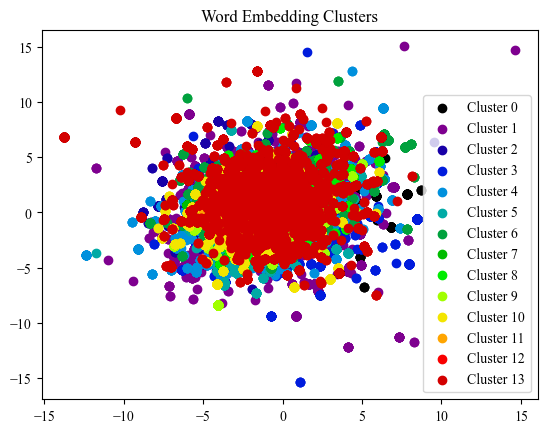

In [21]:
# Visualization (optional)
colors = [plt.cm.nipy_spectral(float(i) / num_clusters) for i in range(num_clusters)]

plt.rcParams["font.family"] = "Times New Roman"


for i in range(num_clusters):
    cluster_indices = np.where(cluster_labels == i)[0]
    cluster_embeddings = X[cluster_indices]
    
    plt.scatter(cluster_embeddings[:, 0], cluster_embeddings[:, 1], color=colors[i], label=f"Cluster {i}")

plt.legend()
plt.title("Word Embedding Clusters")
plt.show()

In [17]:

# Set the range of number of clusters to try
num_clusters_range = range(2, 15)

# Store silhouette scores for each number of clusters
silhouette_scores = []

# Store within-cluster sum of squares (WCSS) for each number of clusters
wcss = []

for num_clusters in num_clusters_range:
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    wcss.append(kmeans.inertia_)

    print(f"Number of clusters: {num_clusters}, Silhouette Score: {silhouette_avg}, Inertia: {kmeans.inertia_}")

Number of clusters: 2, Silhouette Score: 0.07317035645246506, Inertia: 193351168.0
Number of clusters: 3, Silhouette Score: 0.053669288754463196, Inertia: 188330784.0
Number of clusters: 4, Silhouette Score: 0.04395512491464615, Inertia: 184528992.0
Number of clusters: 5, Silhouette Score: 0.03381560370326042, Inertia: 181148320.0
Number of clusters: 6, Silhouette Score: 0.03970026969909668, Inertia: 178561296.0
Number of clusters: 7, Silhouette Score: 0.029176753014326096, Inertia: 176721968.0
Number of clusters: 8, Silhouette Score: 0.024611884728074074, Inertia: 174707696.0
Number of clusters: 9, Silhouette Score: 0.034032776951789856, Inertia: 172361600.0
Number of clusters: 10, Silhouette Score: 0.022569550201296806, Inertia: 170682864.0
Number of clusters: 11, Silhouette Score: 0.026656143367290497, Inertia: 169060736.0
Number of clusters: 12, Silhouette Score: 0.031308747828006744, Inertia: 167965632.0
Number of clusters: 13, Silhouette Score: 0.0185248926281929, Inertia: 166472

In this code, the silhouette scores are calculated for a range of cluster numbers (num_clusters_range). The scores are then plotted to help you choose the optimal number of clusters based on the silhouette score. The number of clusters with the highest silhouette score is often considered the most suitable for the given data.

In this code, the within-cluster sum of squares (WCSS) is calculated for a range of cluster numbers (num_clusters_range). The elbow plot will help you visually identify the point where the rate of decrease in WCSS starts to slow down, indicating the optimal number of clusters

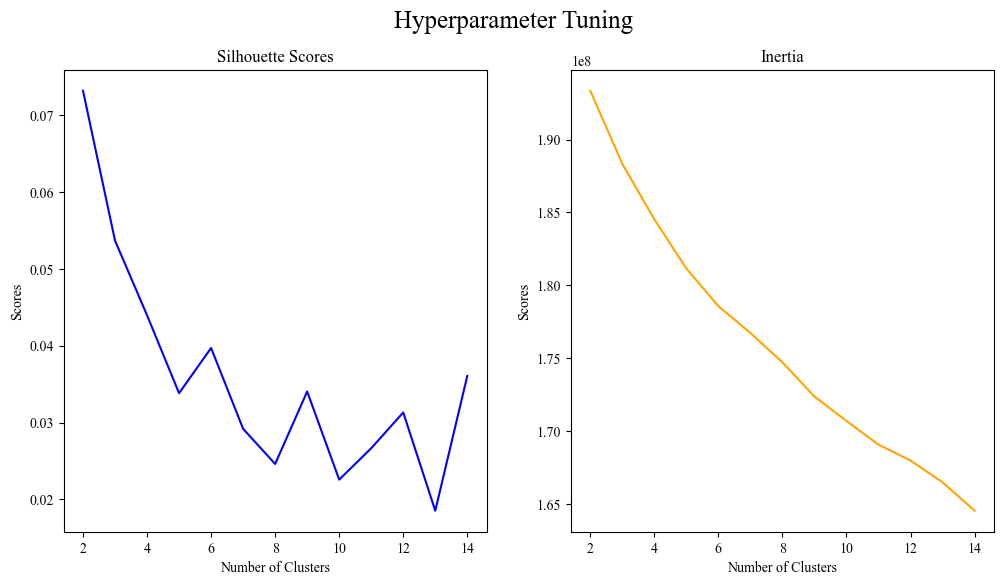

In [28]:


# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first graph
axes[0].plot(num_clusters_range, silhouette_scores, label='sin(x)', color='blue')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Scores')
axes[0].set_title('Silhouette Scores')

# Plot the second graph
axes[1].plot(num_clusters_range, wcss, label='cos(x)', color='orange')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Scores')
axes[1].set_title('Inertia')

# Adjust layout to prevent overlap
# plt.tight_layout()
plt.suptitle("Hyperparameter Tuning", fontsize = 18)

# Show the plots
plt.show();